In [1]:
!pip install gymnasium
!pip install gym-notices

In [2]:
import gymnasium as gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)
plt.style.use('seaborn-v0_8')
import copy
from tqdm.notebook import tqdm

from common import ReplayBuffer, Critic, Actor, DiscreteActor
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda:0" if torch.cuda.is_available() else
                      "cpu")
device = torch.device("cpu")    # actually faster than mps


### Algorithm: Twin Delayed Deep Deterministic policy gradients (TD3)
Implementation based on the [original paper](https://arxiv.org/abs/1802.09477), Open AI's [Spinning Up](https://spinningup.openai.com/en/latest/algorithms/td3.html#) and [Stable-Baselines3](https://github.com/DLR-RM/stable-baselines3/tree/master)

to try:
* OpenAI implementation has layer normalization in both actor and critic networks
* Scheduler for the learning rate and/or the Gumbel-Softmax temperature
* (over-engineering) Wolpertinger policy architecture ([source](https://arxiv.org/abs/1512.07679))
* [Stable Baselines3 hyperparameters](https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/td3.yml)

In [3]:
"""
Hyperparameters
---------------           # [description]; values from      [original paper] / [spinning up]
"""
EXPL_NOISE = 0.5          # std of exploration noise;       0.1  / 0.1
TARGET_ACTION_NOISE = 0.5 # std of target policy noise;     0.2  / 0.2
NOISE_CLIP = 0.5          # clip target policy noise;       0.5  / 0.5
BATCH_SIZE = 256          # for off policy updates;         256  / 128
DISCOUNT = 0.98           # discount factor;                0.99 / 0.99
TAU = 0.001               # target network update rate;     5e-3 / 5e-3
START_TIME = int(1e4)     # pure exploration steps;         1e3  / 1e4
POLICY_UPDATE_PERIOD = 2  # steps between delayed updates;  2    / 2
HIDDEN_DIM = 400          # of actor and critic networks;   256  / 32 
LEARNING_RATE = 1e-3      # of actor and critic networks;   3e-4 / 1e-3
BUFFER_SIZE = 1e6

"""
Algorithm
---------
Twin Delayed Deep Deterministic Policy Gradients
"""
def TD3(env, max_t=int(1e4), n_episodes=2000):

    # all classical control envs have continuous states
    state_dim = env.observation_space.shape[0]

    # check if action space is discrete
    discrete_actions = isinstance(env.action_space, gym.spaces.Discrete)
    if discrete_actions:
        action_dim = 1
        min_action = 0
        max_action = env.action_space.n - 1
        actor = DiscreteActor(state_dim, max_action+1, HIDDEN_DIM).to(device)

    else:   # continuous action space
        action_dim = env.action_space.shape[0]
        assert env.action_space.low.shape == (1,), 'env has action_dim > 1'
        min_action = env.action_space.low[0]
        max_action = env.action_space.high[0]
        actor = Actor(state_dim, action_dim, min_action, max_action, HIDDEN_DIM).to(device)

    target_actor = copy.deepcopy(actor).to(device)
    actor_optimizer = torch.optim.Adam(actor.parameters(), lr=LEARNING_RATE)

    critic_1 = Critic(state_dim, action_dim, HIDDEN_DIM).to(device)
    critic_2 = Critic(state_dim, action_dim, HIDDEN_DIM).to(device)
    target_critic_1 = copy.deepcopy(critic_1).to(device)
    target_critic_2 = copy.deepcopy(critic_2).to(device)
    critic_optimizer = torch.optim.Adam(
        list(critic_1.parameters()) + list(critic_2.parameters()),
        lr=LEARNING_RATE)

    replay_buffer = ReplayBuffer(state_dim, action_dim, BUFFER_SIZE)

    episode = 1
    episodes_reward = []    # reward of each episodes
    episode_reward = 0      # reward of the current episode

    # for debug purposes
    critic_losses = []
    actor_losses = []

    state = env.reset()[0]
    
    episodes_pbar = tqdm(total=n_episodes, position=1)
    episodes_pbar.set_description("Episodes")
    steps_pbar = tqdm(total=max_t, position=0)
    steps_pbar.set_description("Timesteps")
    for step in range(max_t):
        with torch.no_grad():
            if step < START_TIME:
                # Start by exploration
                action = env.action_space.sample()  # outputs (1,) array in continuous envs
            else:
                # Select action with noise
                noise = torch.normal(
                    mean=0.0, std=EXPL_NOISE, size=(1,action_dim)
                    ).to(device)
                action = actor.act(
                    torch.from_numpy(state).squeeze().to(device), noise)
                if discrete_actions:    # Gymnasium expects a single value in this case
                    action = action.item()
                else:                   # and a (1,) array in continous envs
                    action = action.flatten()
                    
            # Execute action and observe
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward

            # for discrete/continuous compatibility purposes
            if not discrete_actions:
                action = action.item()

            # Store tuple in replay buffer
            replay_buffer.add_entry(state, action, reward, next_state, done)

            # If s' is terminal, reset environment
            if done:
                state = env.reset()[0]
                episode += 1
                episodes_pbar.update(1)
                episodes_pbar.refresh()
                episodes_reward.append(episode_reward)
                episode_reward = 0
                if episode >= n_episodes:
                    break

            else:
                state = next_state

        # Training 
        if step > START_TIME:
            replay_state, replay_action, replay_reward, replay_next_state, replay_done = replay_buffer.sample(BATCH_SIZE)
            
            with torch.no_grad():   # no autograd for target networks
                # Select action with noise
                noise = (torch.normal(
                    mean=0.0, std=TARGET_ACTION_NOISE, size=(BATCH_SIZE, action_dim))
                    .clamp(-NOISE_CLIP, NOISE_CLIP)
                    ).to(device)
                # pretty sure it is replay_state in the paper pseudocode 
                target_action = target_actor.act(replay_next_state, noise).reshape(-1,1)

                # Compute target Q values
                target_Q1 = target_critic_1(replay_next_state, target_action)
                target_Q2 = target_critic_2(replay_next_state, target_action)
                target_Q = torch.minimum(target_Q1, target_Q2)
                y = replay_reward + DISCOUNT*(1-replay_done)*target_Q

            # Compute critic loss (gradient descent)
            Q1 = critic_1(replay_state, replay_action)
            Q2 = critic_2(replay_state, replay_action)
            critic_loss = F.mse_loss(Q1, y) + F.mse_loss(Q2, y)

            # Update critics
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()
            critic_losses.append(critic_loss.item())

            # Delayed policy updates (every d step)
            if (step % POLICY_UPDATE_PERIOD) == 0:
                # Gradient ascent
                actor_loss = -critic_1(replay_state, actor.act(replay_state).reshape(-1,1)).mean()

                # Update actor
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()
                actor_losses.append(actor_loss.item())

                # Update target networks
                for param, target_param in zip(critic_1.parameters(), target_critic_1.parameters()):
                    target_param.data.copy_(TAU*param.data + (1-TAU)*target_param.data)

                for param, target_param in zip(critic_2.parameters(), target_critic_2.parameters()):
                    target_param.data.copy_(TAU*param.data + (1-TAU)*target_param.data)

                for param, target_param in zip(actor.parameters(), target_actor.parameters()):
                    target_param.data.copy_(TAU*param.data + (1-TAU)*target_param.data)

        steps_pbar.update(1)

    actor_losses = np.repeat(actor_losses, POLICY_UPDATE_PERIOD)
    nan_starts = np.empty(START_TIME)
    nan_starts[:] = np.nan
    critic_losses = np.concatenate((nan_starts, critic_losses))
    actor_losses = np.concatenate((nan_starts, actor_losses))
    cumulative_rewards_t = np.cumsum(replay_buffer.reward_buffer)
    
    return cumulative_rewards_t, episodes_reward, critic_losses, actor_losses


### Testing: Continuous environments

In [4]:
continuous_envs = ["MountainCarContinuous-v0", "Pendulum-v1"]
results = {}

def plot_results(results, env_name: str):
    rewards_t, episodes_reward, critic_losses, actor_losses = results[env_name]

    fig, ax1 = plt.subplots()
    critic_plot = ax1.plot(critic_losses, label='critic', color='C0')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Critic loss')
    ax2 = ax1.twinx()
    actor_plot = ax2.plot(actor_losses, label='actor', color='C1')
    ax2.set_ylabel('Actor loss (= -Q1)')
    fig.legend()
    fig.suptitle(f"Losses, {env_name}")
    plt.show()

    plt.figure(figsize=(20,6))
    plt.plot(episodes_reward, '.-', label=env_name)
    plt.xlabel("Episode")
    plt.ylabel("Total episode reward")
    plt.legend()
    plt.show()

In [5]:
env_name = continuous_envs[0]   # MountainCarContinous-v0
env = gym.make(env_name)
env.reset(seed=0)

torch.manual_seed(0)

"""
Hyperparameters
---------------           # [description]; values from      [original paper] / [spinning up]
"""
EXPL_NOISE = 0.5          # std of e xploration noise;      0.1  / 0.1
TARGET_ACTION_NOISE = 0.2 # std of target policy noise;     0.2  / 0.2
NOISE_CLIP = 0.5          # clip target policy noise;       0.5  / 0.5
BATCH_SIZE = 256          # for off policy updates;         256  / 128
DISCOUNT = 0.99           # discount factor;                0.99 / 0.99
TAU = 5e-3                # target network update rate;     5e-3 / 5e-3
START_TIME = int(100)       # pure exploration steps;         1e3  / 1e4
POLICY_UPDATE_PERIOD = 2  # steps between delayed updates;  2    / 2
HIDDEN_DIM = 400           # of actor and critic networks;   256  / 32 
LEARNING_RATE = 1e-3      # of actor and critic networks;   3e-4 / 1e-3
BUFFER_SIZE = 1e5

rewards_t, episodes_reward, critic_losses, actor_losses = TD3(env, max_t=int(3e4), n_episodes=2000)
results[env_name] = (rewards_t, episodes_reward, critic_losses, actor_losses)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

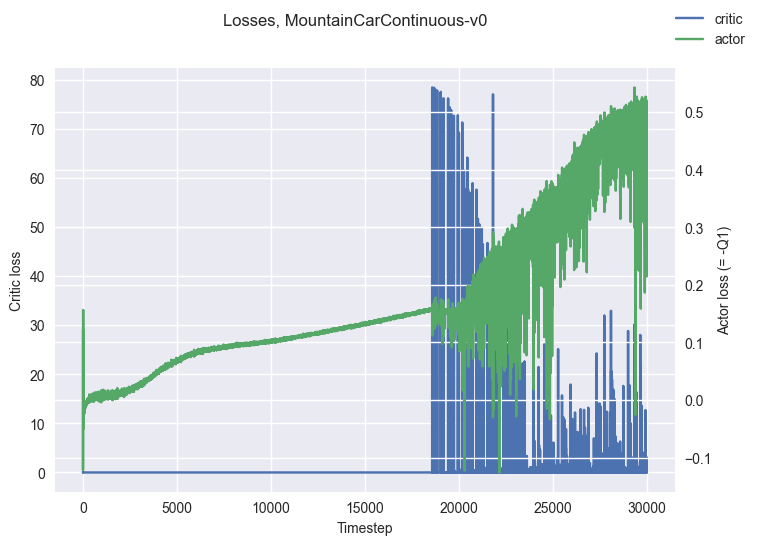

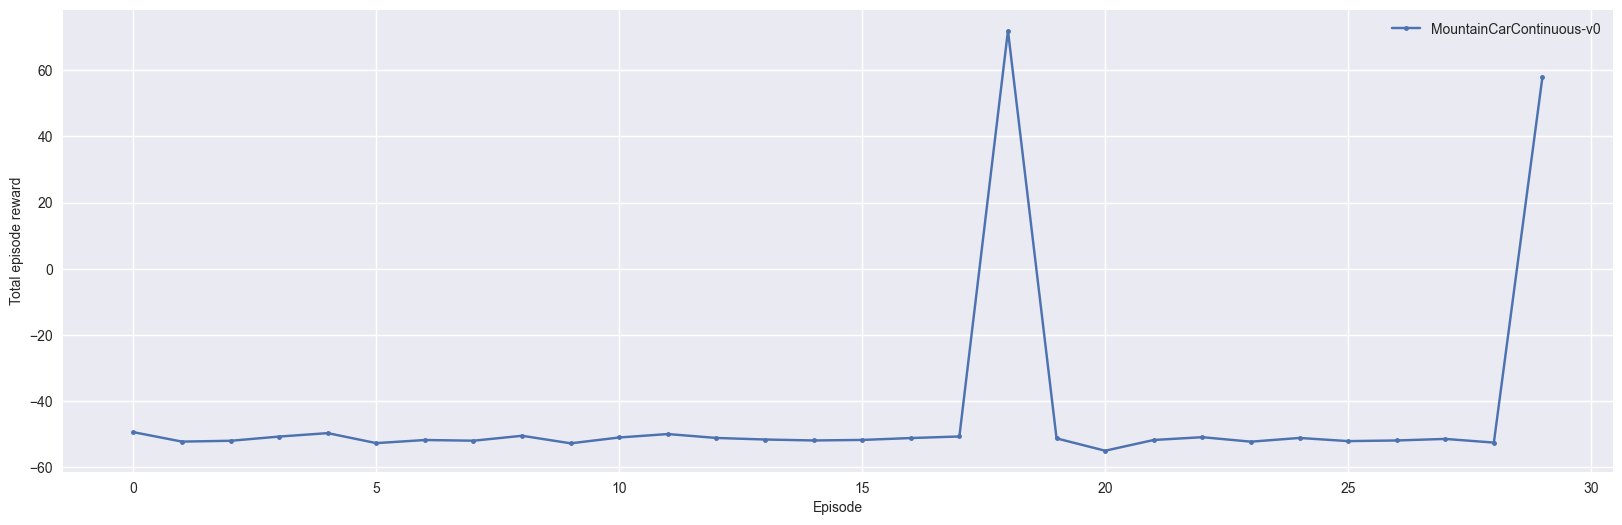

In [6]:
plot_results(results, env_name)
    

### Observations

* TD3 does not need a purely exploratory phase at the beginning to reach the top of the hill if its actions are perturbed with sufficiently large noise. I guess that, with the noise being centered at 0 and the action space ranging from -1 to 1, the car can hazardly move frontwards and backwards until it reaches the top.
* Schedule exploration noise ?

In [10]:
env_name = continuous_envs[1]   # Pendulum-v1
env = gym.make(env_name)
env.reset(seed=0)

torch.manual_seed(0)

"""
Hyperparameters
---------------           # [description]; values from      [original paper] / [spinning up]

EXPL_NOISE = 0.5          # std of e xploration noise;      0.1  / 0.1
TARGET_ACTION_NOISE = 0.5 # std of target policy noise;     0.2  / 0.2
NOISE_CLIP = 0.5          # clip target policy noise;       0.5  / 0.5
BATCH_SIZE = 128          # for off policy updates;         256  / 128
DISCOUNT = 0.99           # discount factor;                0.99 / 0.99
TAU = 5e-3                # target network update rate;     5e-3 / 5e-3
START_TIME = int(0)       # pure exploration steps;         1e3  / 1e4
POLICY_UPDATE_PERIOD = 2  # steps between delayed updates;  2    / 2
HIDDEN_DIM = 256          # of actor and critic networks;   256  / 32 
LEARNING_RATE = 1e-3      # of actor and critic networks;   3e-4 / 1e-3
BUFFER_SIZE = 1e3
"""
"""
Hyperparameters
---------------           # [description]; values from      [original paper] / [spinning up]
"""
EXPL_NOISE = 0.1          # std of e xploration noise;      0.1  / 0.1
TARGET_ACTION_NOISE = 0.2 # std of target policy noise;     0.2  / 0.2
NOISE_CLIP = 0.5          # clip target policy noise;       0.5  / 0.5
BATCH_SIZE = 256          # for off policy updates;         256  / 128
DISCOUNT = 0.98           # discount factor;                0.99 / 0.99
TAU = 5e-3                # target network update rate;     5e-3 / 5e-3
START_TIME = int(1e2)     # pure exploration steps;         1e3  / 1e4
POLICY_UPDATE_PERIOD = 2  # steps between delayed updates;  2    / 2
HIDDEN_DIM = 400          # of actor and critic networks;   256  / 32 
LEARNING_RATE = 1e-3      # of actor and critic networks;   3e-4 / 1e-3
BUFFER_SIZE = 1e5


rewards_t, episodes_reward, critic_losses, actor_losses = TD3(env, max_t=int(2e4), n_episodes=2000)
results[env_name] = (rewards_t, episodes_reward, critic_losses, actor_losses)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

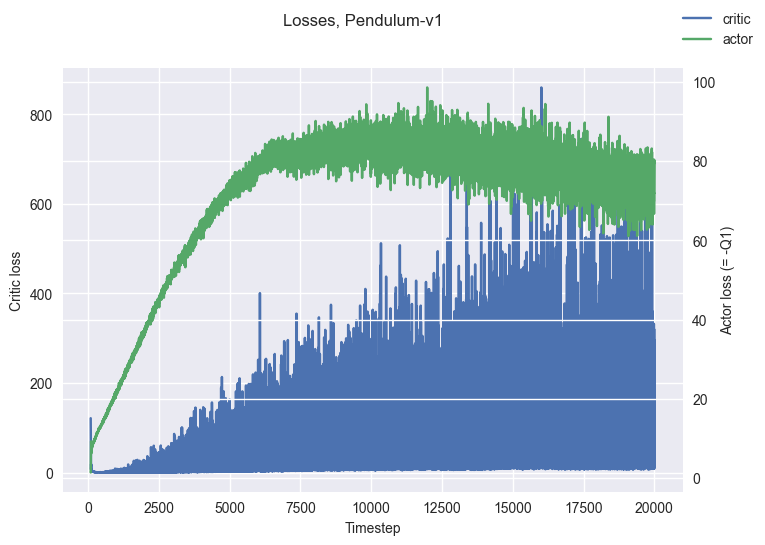

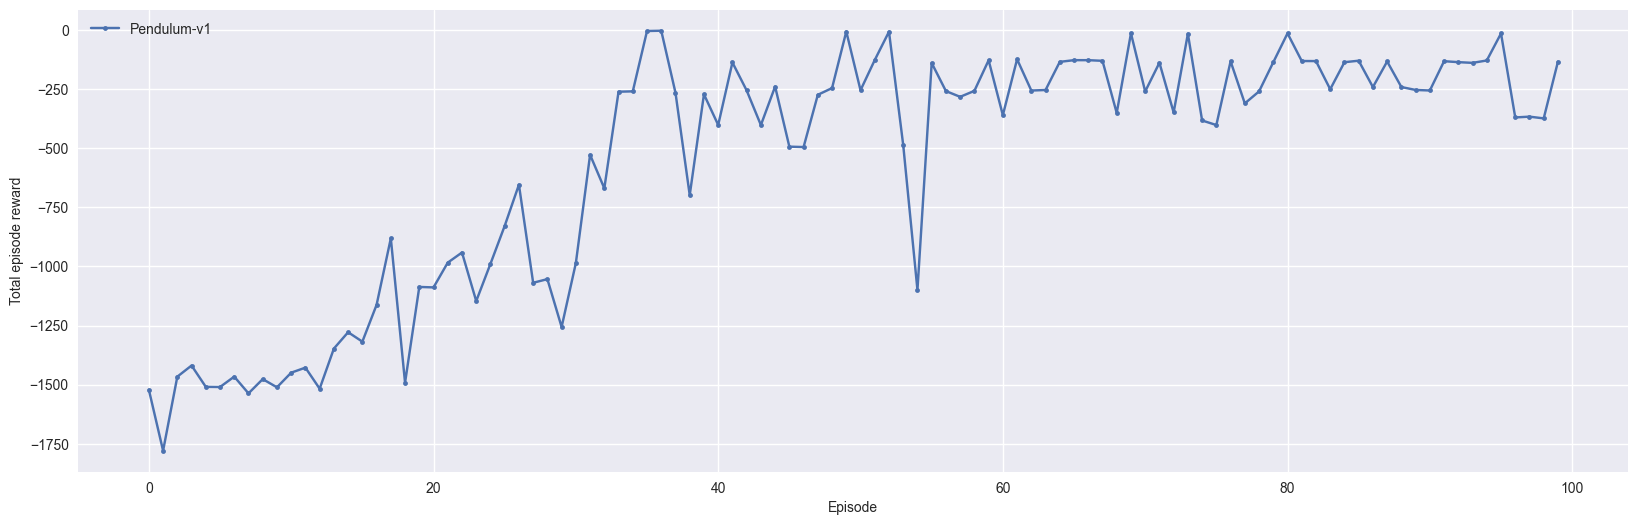

In [11]:
plot_results(results, env_name)

### Experimental: Discrete environments

Relies on the Gumbel-Softmax reparameterization trick to sample discrete actions, which should be incompatible with the deterministic policy assumption of TD3. See class `DiscreteActor` in file [common.py](common.py)

In [9]:
discrete_envs = ["Acrobot-v1", "CartPole-v1", "MountainCar-v0"]
